# Modeling

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA


# Import the data files

In [3]:
New_Jersey_df = pd.read_csv('./cleaned_data/new_jersey')

In [4]:
New_Jersey_df.head(3)

,as_of_date,total_staff_cases,staff_recovered,total_staff_deaths,total_prisoner_cases,prisoners_recovered,total_prisoner_deaths
0,2020-03-26,4.0,NaN,0.0,0.0,NaN,0.0
1,2020-04-01,26.0,NaN,0.0,0.0,NaN,0.0
2,2020-04-08,110.0,NaN,NaN,18.0,NaN,0.0


# Set the date columns to be the indices

In [5]:
New_Jersey_df['as_of_date'] = pd.to_datetime(New_Jersey_df['as_of_date'])
New_Jersey_df.set_index('as_of_date', inplace=True)
New_Jersey_df.sort_index(inplace=True)

In [6]:
New_Jersey_df.head()

,total_staff_cases,staff_recovered,total_staff_deaths,total_prisoner_cases,prisoners_recovered,total_prisoner_deaths
as_of_date,,,,,,
2020-03-26,4.0,NaN,0.0,0.0,NaN,0.0
2020-04-01,26.0,NaN,0.0,0.0,NaN,0.0
2020-04-08,110.0,NaN,NaN,18.0,NaN,0.0
2020-04-15,266.0,NaN,1.0,50.0,NaN,5.0
2020-04-22,427.0,NaN,2.0,101.0,NaN,16.0


# Autocorrelation & Partial Autocorrelation

In [7]:
#new dataframe with just the information we want - prisoner cases
New_Jersey_prisoner_cases = pd.DataFrame(New_Jersey_df['total_prisoner_cases'])

In [8]:
New_Jersey_prisoner_cases.dropna(inplace=True)
New_Jersey_prisoner_cases.shape

(56, 1)

In [9]:
New_Jersey_prisoner_cases.head()

,total_prisoner_cases
as_of_date,
2020-03-26,0.0
2020-04-01,0.0
2020-04-08,18.0
2020-04-15,50.0
2020-04-22,101.0


In [10]:
# New_Jersey_prisoner_cases.to_excel('./NJ_prisoner_cases.xlsx')

In [11]:
#creating 3 lags
New_Jersey_prisoner_cases['total_prisoner_cases_lag1']=New_Jersey_prisoner_cases['total_prisoner_cases'].shift(1)
New_Jersey_prisoner_cases['total_prisoner_cases_lag2']=New_Jersey_prisoner_cases['total_prisoner_cases'].shift(2)
New_Jersey_prisoner_cases['total_prisoner_cases_lag3']=New_Jersey_prisoner_cases['total_prisoner_cases'].shift(3)

In [12]:
#checking our data
New_Jersey_prisoner_cases.head()

,total_prisoner_cases,total_prisoner_cases_lag1,total_prisoner_cases_lag2,total_prisoner_cases_lag3
as_of_date,,,,
2020-03-26,0.0,NaN,NaN,NaN
2020-04-01,0.0,0.0,NaN,NaN
2020-04-08,18.0,0.0,0.0,NaN
2020-04-15,50.0,18.0,0.0,0.0
2020-04-22,101.0,50.0,18.0,0.0


In [13]:
#examining correlation between 3 lags
New_Jersey_prisoner_cases.corr()

,total_prisoner_cases,total_prisoner_cases_lag1,total_prisoner_cases_lag2,total_prisoner_cases_lag3
total_prisoner_cases,1.000000,0.994287,0.980635,0.960384
total_prisoner_cases_lag1,0.994287,1.000000,0.994103,0.979978
total_prisoner_cases_lag2,0.980635,0.994103,1.000000,0.993899
total_prisoner_cases_lag3,0.960384,0.979978,0.993899,1.000000


In [14]:
acf(New_Jersey_prisoner_cases['total_prisoner_cases'],nlags=12)

/Users/merylduff/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([1.        , 0.93689582, 0.86266808, 0.78003578, 0.69206919,
       0.60094685, 0.50720598, 0.41355476, 0.32981645, 0.25262992,
       0.19636143, 0.15160219, 0.11630476])

In [15]:
# Across entire data set, how is it correlated to 1 lag before

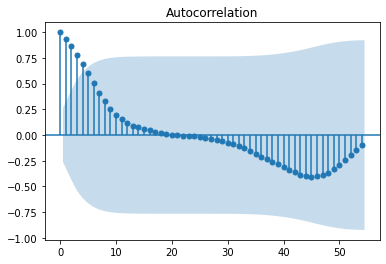

In [16]:
#Plotting autocorrelation 1st 54 lags
plot_acf(New_Jersey_prisoner_cases['total_prisoner_cases'], lags = 54, alpha = 0.05);

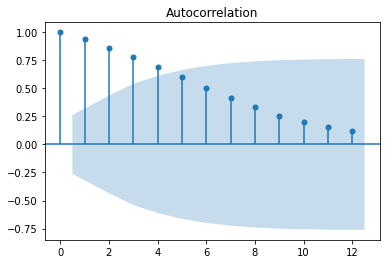

In [17]:
# Relationship between lags is statisticaly significant to 5 lags
plot_acf(New_Jersey_prisoner_cases['total_prisoner_cases'], lags = 12, alpha = 0.05);

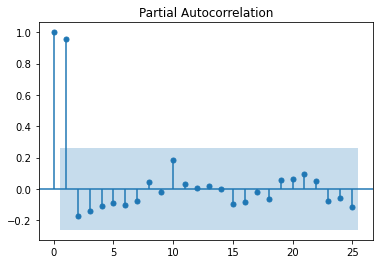

In [18]:
# Partial Auto Correlation - statistially significant at 1 lag (1 week)
plot_pacf(New_Jersey_prisoner_cases['total_prisoner_cases'], lags = 25, alpha=.05);


# Linear Time Series Model


In [19]:
import statsmodels.api as sm

In [20]:
#choosing 2 lags for our first linear model
New_Jersey_prisoner_cases.drop(columns= 'total_prisoner_cases_lag3', inplace = True)
New_Jersey_prisoner_cases.head()

,total_prisoner_cases,total_prisoner_cases_lag1,total_prisoner_cases_lag2
as_of_date,,,
2020-03-26,0.0,NaN,NaN
2020-04-01,0.0,0.0,NaN
2020-04-08,18.0,0.0,0.0
2020-04-15,50.0,18.0,0.0
2020-04-22,101.0,50.0,18.0


In [21]:
#Create variable "time" to take into account how many weeks have passed since the beginning of our time series
New_Jersey_prisoner_cases['time'] = range(0, New_Jersey_prisoner_cases.shape[0])
New_Jersey_prisoner_cases.head()

,total_prisoner_cases,total_prisoner_cases_lag1,total_prisoner_cases_lag2,time
as_of_date,,,,
2020-03-26,0.0,NaN,NaN,0
2020-04-01,0.0,0.0,NaN,1
2020-04-08,18.0,0.0,0.0,2
2020-04-15,50.0,18.0,0.0,3
2020-04-22,101.0,50.0,18.0,4


In [22]:
New_Jersey_prisoner_cases.sort_index(inplace=True)

In [23]:
# Train Test Split
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(New_Jersey_prisoner_cases.drop(columns = 'total_prisoner_cases'),#using lagged data to model 
                                                   New_Jersey_prisoner_cases['total_prisoner_cases'],#seeking to predict prisoner cases 
                                                   test_size=.20, #trying to make the training set bigger
                                                   shuffle = False) #turn shuff off to keep time linear

In [24]:
# Check shape to confirm we did this properly.

print(X_train_lm.shape)
print(X_test_lm.shape)
print(y_train_lm.shape)
print(y_test_lm.shape)

(44, 3)
(12, 3)
(44,)
(12,)


In [25]:
#adding contstant to the X_train and X_test sets
X_train_lm = sm.add_constant(X_train_lm)
X_test_lm = sm.add_constant(X_test_lm)

# Confirm.
X_train_lm.head()

,const,total_prisoner_cases_lag1,total_prisoner_cases_lag2,time
as_of_date,,,,
2020-03-26,1.0,NaN,NaN,0
2020-04-01,1.0,0.0,NaN,1
2020-04-08,1.0,0.0,0.0,2
2020-04-15,1.0,18.0,0.0,3
2020-04-22,1.0,50.0,18.0,4


In [26]:
# statsmodels won't be able to handle missing values.

X_train_lm.dropna(inplace=True)
y_train_lm = y_train_lm[X_train_lm.index] 

# This way we subset y_train to keep only indices from X_train.

In [27]:
X_train_lm.shape

(42, 4)

In [28]:
lm = sm.OLS(endog=y_train_lm, exog=X_train_lm)

lm_results = lm.fit()

print(lm_results.summary())

                             OLS Regression Results                             
Dep. Variable:     total_prisoner_cases   R-squared:                       0.990
Model:                              OLS   Adj. R-squared:                  0.989
Method:                   Least Squares   F-statistic:                     1276.
Date:                  Mon, 19 Apr 2021   Prob (F-statistic):           3.61e-38
Time:                          10:49:37   Log-Likelihood:                -256.96
No. Observations:                    42   AIC:                             521.9
Df Residuals:                        38   BIC:                             528.9
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

In [29]:
lm_results.predict(X_test_lm)

as_of_date
2021-01-26    4221.485842
2021-02-02    4524.784232
2021-02-09    4304.970015
2021-02-16    4309.607024
2021-02-23    4414.598743
2021-03-02    4376.679251
2021-03-09    4722.845999
2021-03-16    4789.837541
2021-03-23    4706.615967
2021-03-30    4711.252976
2021-04-06    4715.889986
2021-04-13    4720.526995
dtype: float64

In [30]:
from sklearn.metrics import r2_score, mean_squared_error

In [31]:
#R2 score
r2_score(y_true=y_test_lm, y_pred=lm_results.predict(X_test_lm))

0.7009987852477135

In [34]:
#RMSE - off by about 100 prisoner cases
mean_squared_error(y_true=y_test_lm, y_pred=lm_results.predict(X_test_lm), squared=False)

98.86643457091988

''

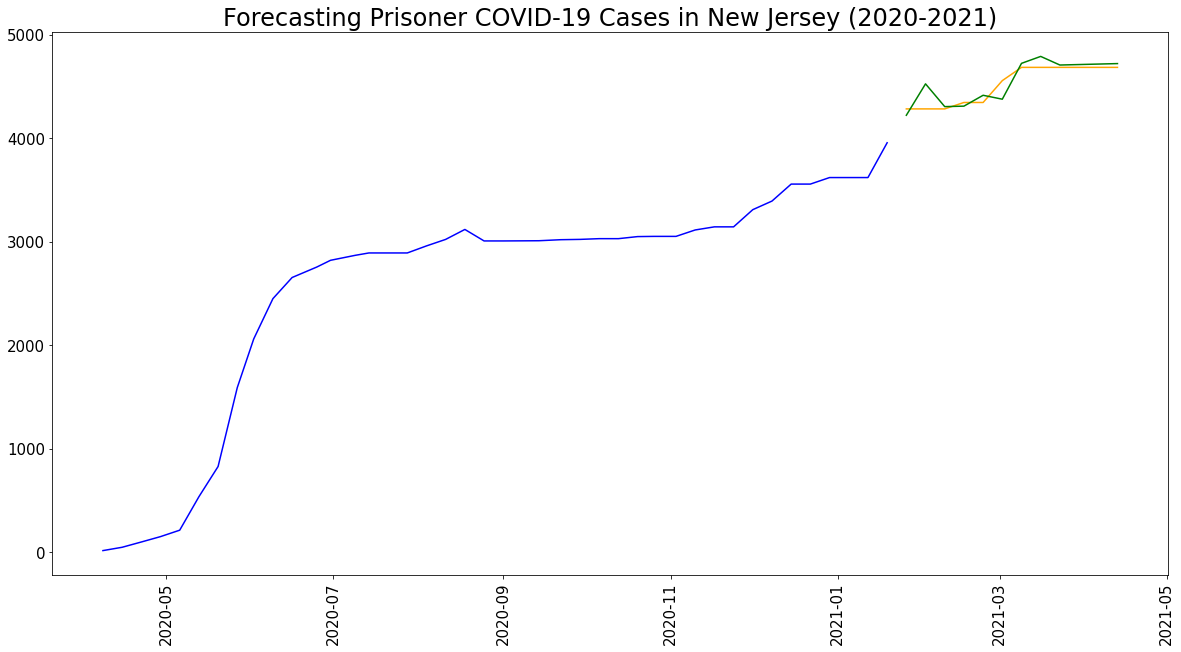

In [35]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train_lm.index, y_train_lm.values, color = 'blue')

# Plot testing data.
plt.plot(y_test_lm.index, y_test_lm.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test_lm), color = 'green')

# Set label.
plt.title(label = 'Forecasting Prisoner COVID-19 Cases in New Jersey (2020-2021)', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xticks(rotation = 90)
;

# Linear Time Series Model with 1 lag

In [36]:
#choosing 1 lag
New_Jersey_prisoner_cases.drop(columns=['total_prisoner_cases_lag2'], inplace = True)
New_Jersey_prisoner_cases.head()

,total_prisoner_cases,total_prisoner_cases_lag1,time
as_of_date,,,
2020-03-26,0.0,NaN,0
2020-04-01,0.0,0.0,1
2020-04-08,18.0,0.0,2
2020-04-15,50.0,18.0,3
2020-04-22,101.0,50.0,4


In [37]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(New_Jersey_prisoner_cases.drop(columns = 'total_prisoner_cases'),#using lagged data to model 
                                                   New_Jersey_prisoner_cases['total_prisoner_cases'],#seeking to predict prisoner cases 
                                                   test_size=.20, #trying to make the training set bigger
                                                   shuffle = False) #turn shuff off to keep time linear

In [38]:
# Check shape to confirm we did this properly.

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(44, 2)
(12, 2)
(44,)
(12,)


In [39]:
#adding contstant to the X_train and X_test sets
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Confirm.
X_train.head()

,const,total_prisoner_cases_lag1,time
as_of_date,,,
2020-03-26,1.0,NaN,0
2020-04-01,1.0,0.0,1
2020-04-08,1.0,0.0,2
2020-04-15,1.0,18.0,3
2020-04-22,1.0,50.0,4


In [40]:
# statsmodels won't be able to handle missing values.

X_train.dropna(inplace=True)
y_train = y_train[X_train.index] 

# This way we subset y_train to keep only indices from X_train.

In [41]:
X_train.shape

(43, 3)

In [42]:
lm1 = sm.OLS(endog=y_train, exog=X_train)

In [43]:
lm1_results = lm1.fit()

In [44]:
print(lm1_results.summary())

                             OLS Regression Results                             
Dep. Variable:     total_prisoner_cases   R-squared:                       0.983
Model:                              OLS   Adj. R-squared:                  0.983
Method:                   Least Squares   F-statistic:                     1187.
Date:                  Mon, 19 Apr 2021   Prob (F-statistic):           2.45e-36
Time:                          10:50:26   Log-Likelihood:                -276.35
No. Observations:                    43   AIC:                             558.7
Df Residuals:                        40   BIC:                             564.0
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

In [45]:
lm1_results.predict(X_test)

as_of_date
2021-01-26    3990.386482
2021-02-02    4303.461454
2021-02-09    4303.900198
2021-02-16    4304.338942
2021-02-23    4364.054280
2021-03-02    4364.493024
2021-03-09    4566.663401
2021-03-16    4689.479629
2021-03-23    4689.918373
2021-03-30    4690.357117
2021-04-06    4690.795861
2021-04-13    4691.234605
dtype: float64

In [46]:
#R2 score
r2_score(y_true=y_test, y_pred=lm1_results.predict(X_test))

0.6453090291459107

In [47]:
#MSE - off by about 100 prisoner cases
mean_squared_error(y_true=y_test, y_pred=lm1_results.predict(X_test), squared=False)

107.68059895968528

''

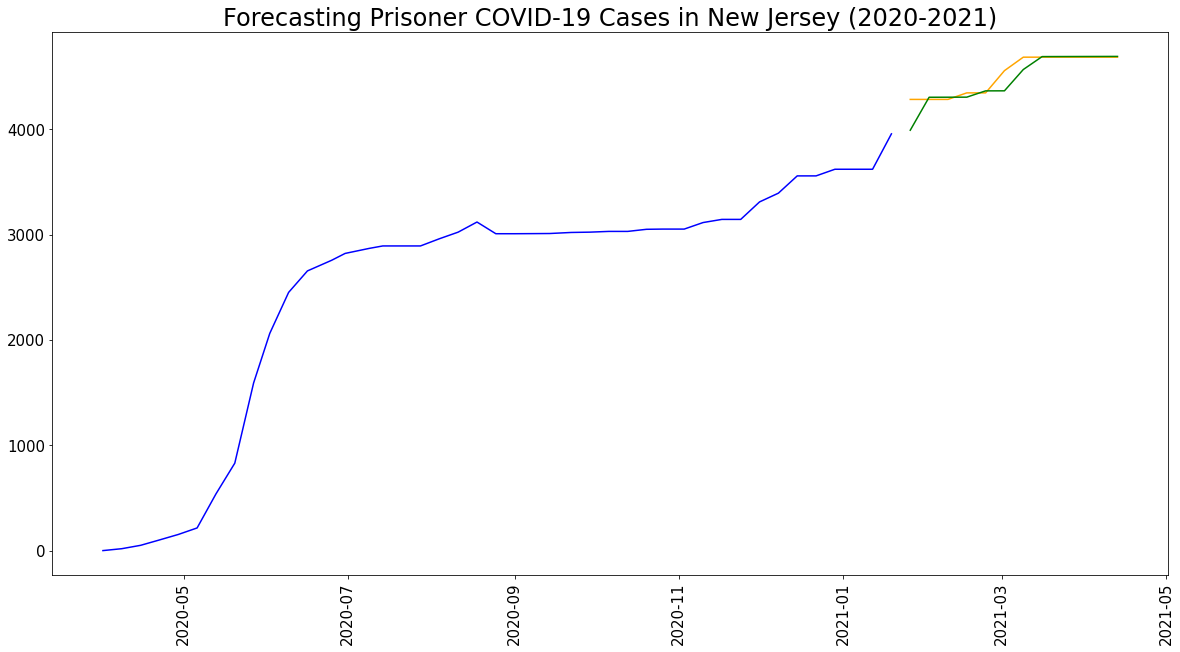

In [48]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm1_results.predict(X_test), color = 'green')

# Set label.
plt.title(label = 'Forecasting Prisoner COVID-19 Cases in New Jersey (2020-2021)', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xticks(rotation = 90)
;

# ARIMA Model

**ARIMA Modeling:**

   ARIMA models are able to handle moderately sized datasets with both long term data and data that has sudden changes. We can easily extend it to a more complex model if we want. The downside to this is that we can only predict in the short term. Since COVID-related data is only about 1 year old, we (hopefully) won't be forecasting for very far into the future, however if prison-related COVID-19 cases grow more rapidly than the general population, forecasting cases in each state may be helpful in vaccine distribution.
    
   For this ARIMA model we will use AIC (Akaike Information Criterion, an attribute in statsmodels) to evaluate.
   
We will test the data for stationarity, then difference. ["A time series has stationarity if a shift in time doesn’t cause a change in the shape of the distribution. Basic properties of the distribution like the mean , variance and covariance are constant over time."](https://www.statisticshowto.com/stationarity/)

In [49]:
nj_diff = pd.DataFrame(New_Jersey_df['total_prisoner_cases'])

In [50]:
nj_diff.head()

,total_prisoner_cases
as_of_date,
2020-03-26,0.0
2020-04-01,0.0
2020-04-08,18.0
2020-04-15,50.0
2020-04-22,101.0


In [51]:
#Aggregate data to weekly because the ARIMA model needs correct frequency
nj_diff = nj_diff.resample('W').sum()

In [52]:
nj_diff['first_diff_total_prisoner_cases'] = nj_diff['total_prisoner_cases'].diff()
nj_diff['sec_diff_total_prisoner_cases'] = nj_diff['total_prisoner_cases'].diff(1).diff(1)
nj_diff['time'] = range(0, nj_diff.shape[0])

In [53]:
nj_diff.head(10)

,total_prisoner_cases,first_diff_total_prisoner_cases,sec_diff_total_prisoner_cases,time
as_of_date,,,,
2020-03-29,0.0,NaN,NaN,0
2020-04-05,0.0,0.0,NaN,1
2020-04-12,18.0,18.0,18.0,2
2020-04-19,50.0,32.0,14.0,3
2020-04-26,101.0,51.0,19.0,4
2020-05-03,153.0,52.0,1.0,5
2020-05-10,215.0,62.0,10.0,6
2020-05-17,538.0,323.0,261.0,7
2020-05-24,830.0,292.0,-31.0,8



*from DSIR-Lancelot/10.03-lesson-ARIMA*

Checking for Stationarity: the Augmented Dickey-Fuller Test
The augmented Dickey-Fuller test is a hypothesis test that tests for stationarity. We assume that our data are not stationary. With enough evidence, we may accept that our data are stationary.

Specifically, the test is as follows:

$$
\begin{eqnarray}
&H_0&:\text{not stationary} \\
&H_A&: \text{stationary}
\end{eqnarray}
$$

In [54]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

In [55]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(nj_diff['total_prisoner_cases']))

Test Statistic   -2.142108
p-value           0.227923
dtype: float64

**The p-value is above .05, we can conclude that the data is stationary - therefore we will NOT difference**

In [56]:
# interpret_dftest(adfuller(nj_diff['first_diff_total_prisoner_cases'].dropna()))

In [57]:
#lets drop the second differenced column
nj_diff.drop(columns=['first_diff_total_prisoner_cases','sec_diff_total_prisoner_cases'], inplace=True)

In [58]:
# Train Test Split - it is univariate, so we don't need to create the Xtrain/Xtest
y_train, y_test = train_test_split(nj_diff['total_prisoner_cases'],
                                   test_size=.1, #trying to make the training set bigger
                                   shuffle = False) #turn shuff off to keep time linear

In [57]:
# nj_diff['first_diff_total_prisoner_cases']

*from DSIR-Lancelot/10.03-lesson-ARIMA*

**There are three hyperparameters when fitting an ARIMA model.**

**Determine a value of $d$ using the Augmented Dickey-Fuller test.**

**Then, determine values of $p$ and $q$ through GridSearching.**

**An $ARIMA(p, d, q)$ model is specified by:**

**how many differences $d$ we need to calculate in order to achieve stationarity**

**how many lags $p$ we regress $Y_t^{(d)}$ on.**

**how many errors $q$ we regress $Y_t^{(d)}$ on.**

$p$ = lags

$d$ = differences

$q$ = errors 

In [59]:
# Instantiate best model.
model = ARIMA(endog = y_train.dropna(), # endog = Y variable
              order = (1,0,3))

# Fit ARIMA model.
arima = model.fit()

/Users/merylduff/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [60]:
# Generate predictions based on test set.
preds = arima.predict(start = y_test.index[0],
                      end = y_test.index[-1])

In [61]:
mean_squared_error(y_test,preds, squared=False)

31.01188828718059

In [62]:
r2_score(y_true=y_test, y_pred=preds)

0.0

### The ARIMA Model was not useful in predicting future COVID-19 cases

# Generating our Predictions

In [94]:
#getting the data from the last record in the X_test
X_test.tail()

,const,total_prisoner_cases_lag1,time
as_of_date,,,
2021-03-16,1.0,4684.0,51
2021-03-23,1.0,4684.0,52
2021-03-30,1.0,4684.0,53
2021-04-06,1.0,4684.0,54
2021-04-13,1.0,4684.0,55


In [146]:
#creating a new dataframe with next date to predict

xnew = pd.DataFrame(X_test_lm.loc['2021-04-13']).T
xnew['as_of_date'] = pd.to_datetime('2021-04-20')

In [147]:
#setting the index to as of date, and replacing time with next in series. 
#We do not have any changing data from the last few weeks, so it will stay at 4684

xnew.set_index('as_of_date')
xnew['time']=56
xnew.set_index('as_of_date', inplace=True)
xnew.dtypes

const                        float64
total_prisoner_cases_lag1    float64
total_prisoner_cases_lag2    float64
time                           int64
dtype: object

In [148]:
lm_results.predict(xnew)

as_of_date
2021-04-20    4725.164005
dtype: float64

# Our model is predicting about 4,725 total cases in New Jersey Prisons by Tuesday, April 20th, 2021. This is an increase of 41, or .87%.